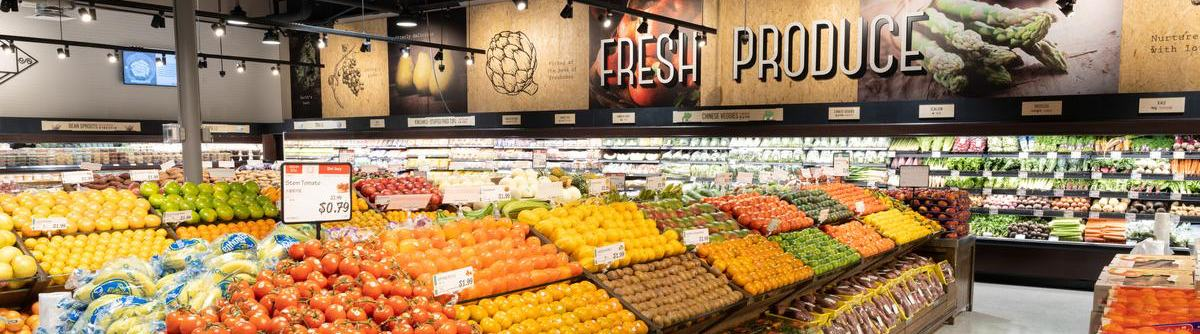

# Predict Future Sales

## Overview
Train data is given a variety of information, but Test data is not given much information. <br/>
So we have to learn Train data in a time series and then predict sales volume for the next month based on Test data. <br/>
We believe that various datasets should be flexibly used to create data that the model can learn. <br/>

#### My Opinion
* 1) Let's visualize the time-series elements of the data to understand the patterns.
* 2) The input dimension of the model learned with Train data should be well thought out and predicted with Test data.

***

## My workflow
#### 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

#### 2. Check out my data
* Check Shape / Info

#### 3. Exploratory Data Analysis(EDA) with Visualization [with Preprocessing]
* Check "item_price", "item_cnt_day" columns outlier
* Plot the Destribute "Shop ID" count of train data
* Plot Destribute "Item Categori" count of train data
* Plot the sales figures for each store.

#### 4. Feature Engineering
* Get "item_cnt_month" column
* Drop rows with columns "date_block_num", "shop_id", and "item_id"
* Collect information about prices for items_id and Normalize prices
* Drop columns what the model does not help to learn.

#### 5.Modeling
##### 1) Arima Modeling
* Get sample data
* Check the "Trend / Seasonal / Residual" in train data
* Check ACF / PACF
* Differencing train data
* ARIMA Modeling
* ARIMA Model's Prediction

##### 2) LightGBM Modeling
* Divide the data into training, testing and evaluatio
* Training

#### 6. Submission
* Submit the predictions

# 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

In [1]:
import re
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler



In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# 2. Check out my data
* Check Shape / Info

In [4]:
item_categories_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
print("item_categories_df Shape : {}".format(item_categories_df.shape))
item_categories_df.head()

item_categories_df Shape : (84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
shops_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
print("items_df Shape : {}".format(items_df.shape))
items_df.head()

items_df Shape : (22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
print("train dataset Shape : {}".format(train_df.shape))
train_df.head()

train dataset Shape : (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
print("train dataset Shape : {}".format(train_df.shape))
print("test dataset Shape : {}".format(test_df.shape))

train dataset Shape : (2935849, 6)
test dataset Shape : (214200, 3)


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


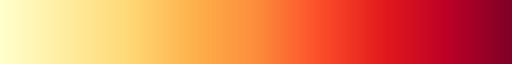

In [11]:
sns.color_palette("YlOrRd",  as_cmap=True)

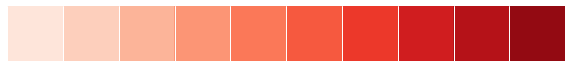

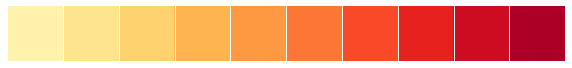

In [12]:
Reds_palette = sns.color_palette("Reds", 10)
YlOrBr_palette = sns.color_palette("YlOrRd", 10)

sns.palplot(Reds_palette)
sns.palplot(YlOrBr_palette)

#### ✔️ This notebook will use this palettes.

# 3. Exploratory Data Analysis(EDA) with Visualization [with Preprocessing]
* Check "item_price", "item_cnt_day" columns outlier
* Plot the Destribute "Shop ID" count of train data
* Plot Destribute "Item Categori" count of train data
* Plot the sales figures for each store.

In [13]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### 3-1) Check "item_price", "item_cnt_day" columns outlier

In [14]:
pd.DataFrame(train_df.iloc[:, 4].sort_values(ascending=False)).head(10).style.background_gradient(cmap='Reds')

,item_price
1163158,307980.000000
885138,59200.000000
1488135,50999.000000
2327159,49782.000000
2910156,42990.000000
2931380,42990.000000
2917760,42990.000000
2885692,42990.000000
1006638,42000.000000
2893100,41990.000000


In [15]:
pd.DataFrame(train_df.iloc[:, 5].sort_values(ascending=False)).head(10).style.background_gradient(cmap='YlOrBr')

,item_cnt_day
2909818,2169.000000
2326930,1000.000000
2864235,669.000000
2851091,637.000000
2608040,624.000000
2626181,539.000000
2851073,533.000000
2048518,512.000000
2067669,508.000000
2864260,504.000000


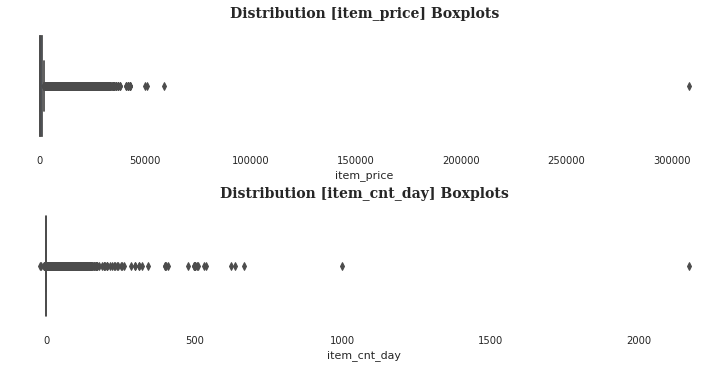

In [16]:
fig, axes = plt.subplots(2,1, figsize=(10,5), constrained_layout=True)

sns.boxplot(train_df['item_price'], ax=axes[0])
axes[0].set_title("Distribution [item_price] Boxplots", fontweight="bold", fontfamily='serif', fontsize=14)
axes[0].patch.set_alpha(0)

sns.boxplot(train_df['item_cnt_day'], ax=axes[1])
axes[1].set_title("Distribution [item_cnt_day] Boxplots", fontweight="bold", fontfamily='serif', fontsize=14)
axes[1].patch.set_alpha(0)

plt.show()

In [17]:
def preporcess_data(df):
    print("Before cleansing shape : {}".format(df.shape))
    print("----- CLEANSING START -----")
    
    # drop outlier value
    df = df.drop(df[df['item_price']>=45000].index)
    df = df.drop(df[df['item_price']<0].index)
    df = df.drop(df[df['item_cnt_day']>=600].index)
    df = df.drop(df[df['item_cnt_day']<0].index)
    print(df.shape)
    
    
    print("----- CLEANSING END -----")
    print("After cleansing shape : {}".format(df.shape))
    return df

In [18]:
train_df = preporcess_data(train_df)

Before cleansing shape : (2935849, 6)
----- CLEANSING START -----
(2928483, 6)
----- CLEANSING END -----
After cleansing shape : (2928483, 6)


### 3-2) Plot the Destribute "Shop ID" count of train data

In [19]:
Reds_palette_59 = sns.color_palette("Reds", 59)

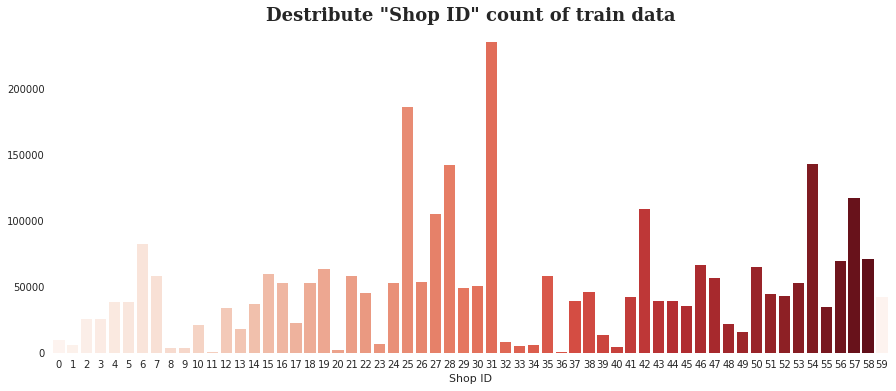

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))

sns.countplot(data=train_df, x='shop_id', ax=ax, palette=Reds_palette_59)
ax.set_title('Destribute "Shop ID" count of train data', fontweight="bold", fontfamily='serif', fontsize=18)
ax.set(xlabel="Shop ID", ylabel = "")
ax.patch.set_alpha(0)
plt.show()

### 3-3) Plot Destribute "Item Categori" count of train data

In [21]:
YlOrBr_palette_89 = sns.color_palette("YlOrRd", 89)

In [22]:
def input_items_key_output_items_value(key):
    return item_dict[key]

In [23]:
item_dict = {key:value for key, value in zip(items_df['item_id'], items_df['item_category_id'])}
print("item_dict size : {}".format(len(item_dict)))

item_dict size : 22170


* Get item_dictionary => ( item_id : item_category_id )

In [24]:
train_df['item_category_id'] = train_df.apply(lambda x : input_items_key_output_items_value(x['item_id']), axis=1)
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56
5,10.01.2013,0,25,2564,349.00,1.0,59


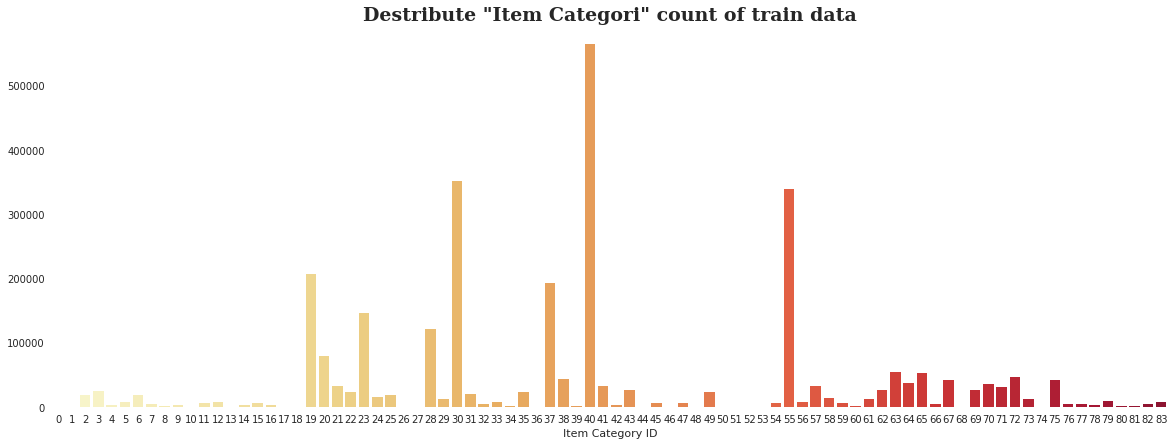

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20,7))

sns.countplot(data=train_df, x='item_category_id', ax=ax, palette=YlOrBr_palette_89)
ax.set_title('Destribute "Item Categori" count of train data', fontweight="bold", fontfamily='serif', fontsize=19)
ax.set(xlabel="Item Category ID", ylabel = "")
ax.patch.set_alpha(0)
plt.show()

### 3-4) Plot the sales figures for each store.
* get "Sales" column => ( "item_price" * "item_cnt_day" )

In [26]:
train_df['sales'] = train_df['item_price'] * train_df['item_cnt_day']
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,sales
0,02.01.2013,0,59,22154,999.00,1.0,37,999.00
1,03.01.2013,0,25,2552,899.00,1.0,58,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,58,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,56,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,59,349.00


In [27]:
def input_shopid_output_sales(tim_data, shop_id):
    shop_sales = []
    for i in range(len(tim_data)):
        a = train_df[(train_df['date_block_num']==i) & (train_df['shop_id']==shop_id)]['sales'].sum()
        shop_sales.append(a)
    
    return shop_sales

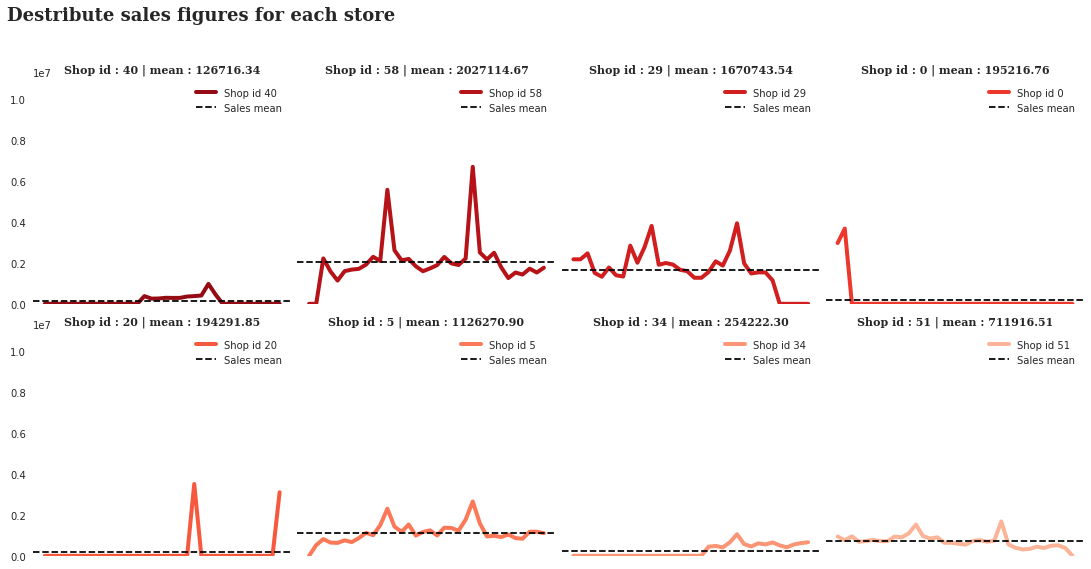

In [28]:
time_data = train_df['date_block_num'].unique()

fig, axes = plt.subplots(2,4, figsize=(15,7), constrained_layout=True)
x_idx = 0
y_idx = 0

for i in range(2*4):
    if x_idx == 4:
        x_idx = 0
        y_idx += 1
        
    random_index = np.random.randint(0,61)
    sales_data = input_shopid_output_sales(time_data, random_index)
    sales_data_mean = np.mean(sales_data)

    
    axes[y_idx][x_idx].plot(sales_data, linewidth=4.0, color=Reds_palette[-1*(i+1)], label='Shop id {}'.format(random_index))
    axes[y_idx][x_idx].axhline(y=sales_data_mean, color='k',linestyle='--', label='Sales mean')
    axes[y_idx][x_idx].set_ylim(0, train_df['sales'].max()*6)
    axes[y_idx][x_idx].set_title("Shop id : {} | mean : {:.2f}".format(random_index, sales_data_mean), fontweight="bold", fontfamily='serif', fontsize=11)
    axes[y_idx][x_idx].legend()
    
    axes[y_idx][x_idx].set_xticks([])
    if x_idx!=0:
        axes[y_idx][x_idx].set_yticks([])
        
    axes[y_idx][x_idx].patch.set_alpha(0)
    x_idx += 1
fig.text(0,1.08, "Destribute sales figures for each store", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

# 4. Feature Engineering
* Get "item_cnt_month" column
* Drop rows with columns "date_block_num", "shop_id", and "item_id"
* Collect information about prices for items_id and Normalize prices
* Drop columns what the model does not help to learn.
* Test data Feature Engineering

### 4-1) Get "item_cnt_month" column

In [29]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,sales
0,02.01.2013,0,59,22154,999.00,1.0,37,999.00
1,03.01.2013,0,25,2552,899.00,1.0,58,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,58,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,56,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,59,349.00


In [30]:
group = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
train_df = pd.merge(train_df, group, on=['shop_id', 'item_id', 'date_block_num'], how='left')
train_df['item_cnt_month'] = (train_df['item_cnt_month']
                        .fillna(0)
                        .clip(0, 100)
                        .astype(np.float16))

In [31]:
train_df[(train_df['shop_id']==31) & (train_df['date_block_num']==0) & (train_df['item_id']==4906)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,sales,item_cnt_month
59988,03.01.2013,0,31,4906,1794.0,2.0,19,3588.0,11.0
59989,02.01.2013,0,31,4906,1789.0,1.0,19,1789.0,11.0
60011,12.01.2013,0,31,4906,1799.0,1.0,19,1799.0,11.0
60013,14.01.2013,0,31,4906,1799.0,1.0,19,1799.0,11.0
60014,19.01.2013,0,31,4906,1799.0,1.0,19,1799.0,11.0


* You can check the same "item_cnt_month" column

### 4-2) Drop rows with columns "date_block_num", "shop_id", and "item_id"

In [32]:
train_df = train_df.drop_duplicates(['date_block_num','shop_id','item_id','item_cnt_month'])
print("train data Shape : {}".format(train_df.shape))
train_df.head()

train data Shape : (1608222, 9)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,sales,item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0,37,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0,58,899.00,1.0
2,06.01.2013,0,25,2554,1709.05,1.0,58,1709.05,1.0
3,15.01.2013,0,25,2555,1099.00,1.0,56,1099.00,1.0
4,10.01.2013,0,25,2564,349.00,1.0,59,349.00,1.0


### 4-3) Collect information about prices for items_id and Normalize prices

In [33]:
Reds_palette_89 = sns.color_palette("Reds", 89)
Reds_palette_100 = sns.color_palette("Reds", 100)

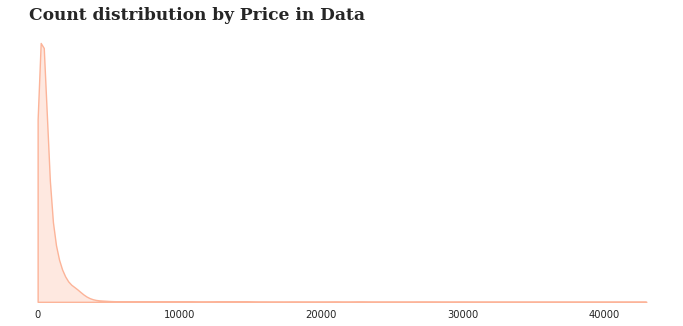

In [34]:
fig, ax = plt.subplots(1,1, figsize=(12,5))


sns.kdeplot(x='item_price', data=train_df, 
                        fill=True, cut=0, bw_method=0.20, color=Reds_palette[2],
                        lw=1.4 , ax=ax, alpha=0.3)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_yticks([])
ax.spines[["top","right","left","bottom"]].set_visible(False)
ax.patch.set_alpha(0)
ax.legend([],[], frameon=False) #remove legend

fig.text(0.15,0.91,"Count distribution by Price in Data", fontweight="bold", fontfamily='serif', fontsize=17)
plt.show()

* Verify that the graph is skewed to one side. We should Standard the data

#### => Get Srandard value in price DataFrame

In [35]:
price_dict = {key:value for key, value in zip(train_df['item_id'], train_df['item_price'])}
print("price_dict size : {}".format(len(price_dict)))

price_dict size : 21801


In [36]:
price_dict_df = pd.DataFrame.from_dict(price_dict, orient='index', columns=['price'])
price_df = price_dict_df.reset_index()
price_df.columns = ['item_id', 'price']

price_df.head()

,item_id,price
0,22154,299.00
1,2552,949.00
2,2554,1709.05
3,2555,1149.00
4,2564,249.00


In [37]:
price_list = []
for val in price_df['price'].values:
    price_list.append([val])
    
print(price_list[:10])

[[299.0], [949.0], [1709.05], [1149.0], [249.0], [549.0], [299.0], [249.0], [449.0], [148.0]]


In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
std_scaler = StandardScaler()

std_scaler.fit(price_list)
std_price = std_scaler.transform(price_list)
std_price_df = pd.DataFrame(std_price, columns=['std_price'])

In [39]:
price_df = pd.concat([price_df, std_price_df], axis=1)
price_df.head()

,item_id,price,std_price
0,22154,299.00,-0.251803
1,2552,949.00,0.120012
2,2554,1709.05,0.554778
3,2555,1149.00,0.234417
4,2564,249.00,-0.280404


In [40]:
std_price_dict = {key: val for key, val in zip(price_df['item_id'], price_df['std_price'])}
print("std_price_dict size : {}".format(len(std_price_dict)))

std_price_dict size : 21801


In [41]:
def input_items_key_output_items_price(key):
    return std_price_dict[key]

train_df['item_price_std'] = train_df.apply(lambda x : input_items_key_output_items_price(x['item_id']), axis=1)

#### => Get Log Transform value in price DataFrame

In [42]:
train_df['item_price_log'] = np.log1p(train_df["item_price"])
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,sales,item_cnt_month,item_price_std,item_price_log
0,02.01.2013,0,59,22154,999.00,1.0,37,999.00,1.0,-0.251803,6.907755
1,03.01.2013,0,25,2552,899.00,1.0,58,899.00,1.0,0.120012,6.802395
2,06.01.2013,0,25,2554,1709.05,1.0,58,1709.05,1.0,0.554778,7.444278
3,15.01.2013,0,25,2555,1099.00,1.0,56,1099.00,1.0,0.234417,7.003065
4,10.01.2013,0,25,2564,349.00,1.0,59,349.00,1.0,-0.280404,5.857933


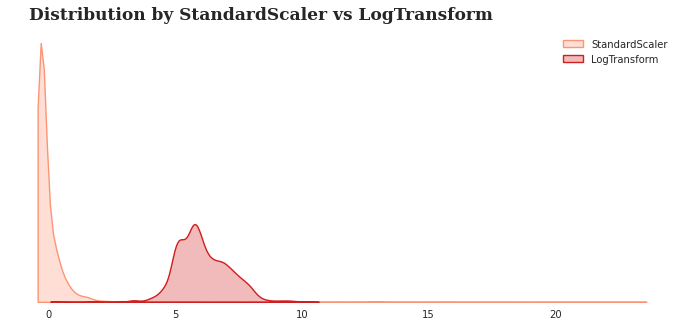

In [43]:
fig, ax = plt.subplots(1,1, figsize=(12,5))


sns.kdeplot(x='item_price_std', data=train_df, 
                        fill=True, cut=0, bw_method=0.20, color=Reds_palette[3],
                        lw=1.4 , ax=ax, alpha=0.3, label='StandardScaler')
sns.kdeplot(x='item_price_log', data=train_df, 
                        fill=True, cut=0, bw_method=0.20, color=Reds_palette[7],
                        lw=1.4 , ax=ax, alpha=0.3, label='LogTransform')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_yticks([])
ax.spines[["top","right","left","bottom"]].set_visible(False)
ax.patch.set_alpha(0)
ax.legend()

fig.text(0.15,0.91,"Distribution by StandardScaler vs LogTransform", fontweight="bold", fontfamily='serif', fontsize=17)
plt.show()

* We use LogTransform Values

### 4-4) Drop columns what the model does not help to learn.

In [44]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,sales,item_cnt_month,item_price_std,item_price_log
0,02.01.2013,0,59,22154,999.00,1.0,37,999.00,1.0,-0.251803,6.907755
1,03.01.2013,0,25,2552,899.00,1.0,58,899.00,1.0,0.120012,6.802395
2,06.01.2013,0,25,2554,1709.05,1.0,58,1709.05,1.0,0.554778,7.444278
3,15.01.2013,0,25,2555,1099.00,1.0,56,1099.00,1.0,0.234417,7.003065
4,10.01.2013,0,25,2564,349.00,1.0,59,349.00,1.0,-0.280404,5.857933


In [45]:
train_df = train_df.drop(['date', 'item_price', 'item_cnt_day', 'sales', 'item_price_std', ], axis=1)
print("train data Shape : {}".format(train_df.shape))
train_df.head()

train data Shape : (1608222, 6)


,date_block_num,shop_id,item_id,item_category_id,item_cnt_month,item_price_log
0,0,59,22154,37,1.0,6.907755
1,0,25,2552,58,1.0,6.802395
2,0,25,2554,58,1.0,7.444278
3,0,25,2555,56,1.0,7.003065
4,0,25,2564,59,1.0,5.857933


### 4-5) Test data Feature Engineering

In [46]:
test_df = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [47]:
test_df['date_block_num'] = 34

In [48]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [49]:
item_dict = {key:value for key, value in zip(items_df['item_id'], items_df['item_category_id'])}
print("item_dict size : {}".format(len(item_dict)))

test_df['item_category_id'] = test_df.apply(lambda x : input_items_key_output_items_value(x['item_id']), axis=1)

item_dict size : 22170


In [50]:
price_df.head()

,item_id,price,std_price
0,22154,299.00,-0.251803
1,2552,949.00,0.120012
2,2554,1709.05,0.554778
3,2555,1149.00,0.234417
4,2564,249.00,-0.280404


In [51]:
id_price_dict = {key: val for key, val in zip(price_df['item_id'], price_df['price'])}
print("id_price_dict size : {}".format(len(std_price_dict)))

id_price_dict size : 21801


In [52]:
def input_items_key_output_items_price_test(key):
    try:
        return_val = id_price_dict[key]
    except:
        return_val = None
    return return_val

test_df['item_price'] = test_df.apply(lambda x : input_items_key_output_items_price_test(x['item_id']), axis=1)

In [53]:
# Get test data's item price based on train data
# If test data that had null values, then I'll use median values

test_df['item_price'].fillna(test_df['item_price'].median(), inplace=True)
print("Value of item median preice : {}".format(test_df['item_price'].median()))

Value of item median preice : 449.0


In [54]:
test_df['item_price_log'] = np.log(test_df['item_price'])

In [55]:
test_df.drop(['ID', 'item_price'],axis=1, inplace=True)
test_df.head()

,shop_id,item_id,date_block_num,item_category_id,item_price_log
0,5,5037,34,19,7.312553
1,5,5320,34,55,6.107023
2,5,5233,34,19,7.089243
3,5,5232,34,23,7.089243
4,5,5268,34,20,6.107023


# 5.Modeling
##### 1) Arima Modeling
* Get sample data
* Check the "Trend / Seasonal / Residual" in train data
* Check ACF / PACF
* Differencing train data
* ARIMA Modeling
* ARIMA Model's Prediction


##### 2) LightGBM Modeling
*


### 5-1) Arima Modeling
##### 5-1-1) Get sample data

In [56]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import itertools

In [57]:
sample_series = pd.DataFrame(train_df[(train_df['shop_id']==29) & (train_df['item_id']==5822)]['item_cnt_month']).reset_index().drop('index',axis=1)
sample_series.head()

,item_cnt_month
0,6.0
1,10.0
2,13.0
3,11.0
4,16.0


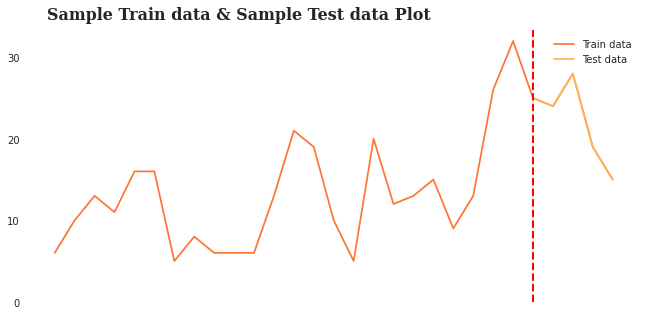

In [58]:
train_sample, test_sample = train_test_split(sample_series, test_size=0.15, shuffle=False)

fig, ax = plt.subplots(1,1, figsize=(11,5))
plt.plot(sample_series, label="Train data", color=YlOrBr_palette[5])
plt.plot(test_sample, label="Test data",color=YlOrBr_palette[3])
plt.axvline(x=len(train_sample), color='r',linestyle='--', linewidth=2)

ax.set_yticks(np.arange(0,31,10))
ax.set_xticks([])

ax.legend()
ax.patch.set_alpha(0)

fig.text(0.15,0.91,"Sample Train data & Sample Test data Plot", fontweight="bold", fontfamily='serif', fontsize=16)
plt.show()

In [59]:
print("Sample Train data size : {}".format(train_sample.shape))
print("Sample Test data size : {}".format(test_sample.shape))

Sample Train data size : (24, 1)
Sample Test data size : (5, 1)


##### 5-1-2) Check the "Trend / Seasonal / Residual" in train data

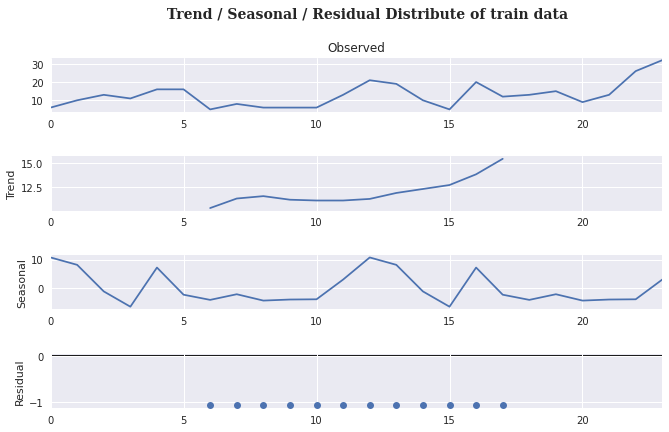

In [60]:
res = sm.tsa.seasonal_decompose(train_sample.values, freq=12, model='addidtive')
fig = res.plot()
fig.set_size_inches(10,6)
fig.text(0.28,1," Trend / Seasonal / Residual Distribute of train data", fontweight="bold", fontfamily='serif', fontsize=14)
plt.show()

##### 5-1-3) Check ACF / PACF
* ACF / PACF are the function that confirms the normality of time series data.

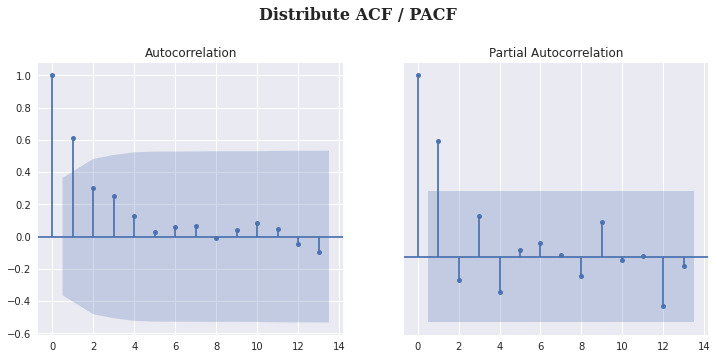

In [61]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

plot_acf(sample_series,lags=13, ax=axes[0])
plot_pacf(sample_series,lags=13, ax=axes[1])
axes[1].set_yticks([])

fig.text(0.38,1,"Distribute ACF / PACF", fontweight="bold", fontfamily='serif', fontsize=16)
plt.show()

##### 5-1-4) Differencing train data
* Non Stationary data is converted into Stationary data through differencing.

In [62]:
diff_train_sample = train_sample.copy()
diff_train_sample = diff_train_sample.diff()
diff_train_sample = diff_train_sample.dropna()
print("=== Basic Data ===")
print(diff_train_sample[:5],"\n\n")

print("=== Diff Data ===")
print(diff_train_sample[:5])

=== Basic Data ===
   item_cnt_month
1             4.0
2             3.0
3            -2.0
4             5.0
5             0.0 


=== Diff Data ===
   item_cnt_month
1             4.0
2             3.0
3            -2.0
4             5.0
5             0.0


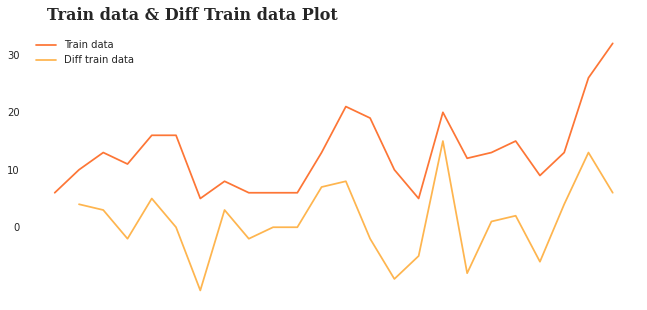

In [63]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
ax.plot(train_sample, label="Train data", color=YlOrBr_palette[5])
ax.plot(diff_train_sample, label="Diff train data",color=YlOrBr_palette[3])

ax.set_yticks(np.arange(0,31,10))
ax.set_xticks([])

ax.legend()
ax.patch.set_alpha(0)

fig.text(0.15,0.91,"Train data & Diff Train data Plot", fontweight="bold", fontfamily='serif', fontsize=16)
plt.show()


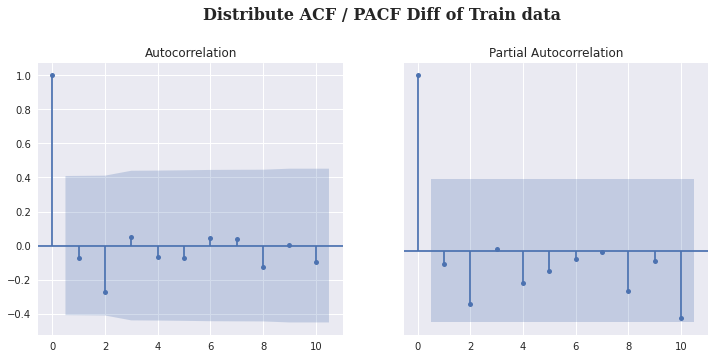

In [64]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

plot_acf(diff_train_sample,lags=10, ax=axes[0])
plot_pacf(diff_train_sample,lags=10, ax=axes[1])
axes[1].set_yticks([])

fig.text(0.315,1,"Distribute ACF / PACF Diff of Train data", fontweight="bold", fontfamily='serif', fontsize=16)
plt.show()

##### 5-1-5) ARIMA Modeling

##### 5-1-6) ARIMA Model's Prediction

In [65]:
p = range(0,5)
d = range(1,2)
q = range(0,5)
pdq = list(itertools.product(p,d,q))
pdq = pdq[1:] # Drop (0,1,0)

print("Using parameters : {}".format(pdq))

Using parameters : [(0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4)]


In [66]:
# Parameter Search
aic = []
for i in pdq:
    model = ARIMA(train_sample.values, order=(i))
    model_fit = model.fit()
    print("ARIMA : {} | AIC : {:.3f}".format(i,model_fit.aic))
    aic.append(model_fit.aic)

ARIMA : (0, 1, 1) | AIC : 155.020
ARIMA : (0, 1, 2) | AIC : 153.662
ARIMA : (0, 1, 3) | AIC : 155.662
ARIMA : (0, 1, 4) | AIC : 157.662
ARIMA : (1, 1, 0) | AIC : 155.087
ARIMA : (1, 1, 1) | AIC : 155.415
ARIMA : (1, 1, 2) | AIC : 155.662
ARIMA : (1, 1, 3) | AIC : 156.740


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA : (1, 1, 4) | AIC : 158.132
ARIMA : (2, 1, 0) | AIC : 154.996
ARIMA : (2, 1, 1) | AIC : 155.812
ARIMA : (2, 1, 2) | AIC : 156.951


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA : (2, 1, 3) | AIC : 158.681


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA : (2, 1, 4) | AIC : 160.304
ARIMA : (3, 1, 0) | AIC : 156.935
ARIMA : (3, 1, 1) | AIC : 157.785


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA : (3, 1, 2) | AIC : 157.794


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA : (3, 1, 3) | AIC : 158.041


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA : (3, 1, 4) | AIC : 161.760
ARIMA : (4, 1, 0) | AIC : 158.167
ARIMA : (4, 1, 1) | AIC : 159.205


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA : (4, 1, 2) | AIC : 158.715


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA : (4, 1, 3) | AIC : 159.993
ARIMA : (4, 1, 4) | AIC : 161.638


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [67]:
best_pdq = [pdq[idx] for idx, num in enumerate(aic) if num==min(aic)][0]
print("Best Parameters : {}".format(best_pdq))

Best Parameters : (0, 1, 2)


In [68]:
arima_model = ARIMA(train_sample.values, order=best_pdq).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -73.831
Date:                Thu, 01 Jul 2021   AIC                            153.662
Time:                        14:20:40   BIC                            157.069
Sample:                             0   HQIC                           154.519
                                 - 24                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2059      0.208     -0.988      0.323      -0.614       0.202
ma.L2         -0.4732      0.318     -1.489      0.137      -1.096       0.150
sigma2        34.9167     12.694      2.751      0.006      10.038      59.796
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.80   Prob(JB):                         0.69
Heteroskedasticity (H):               3.14   Skew:                             0.12
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### 5-1-6) ARIMA Model's Prediction

In [69]:
pred = arima_model.forecast(len(test_sample))
print("Prdiction values : {}".format(pred))

Prdiction values : [24.38608179 19.7418757  19.7418757  19.7418757  19.7418757 ]


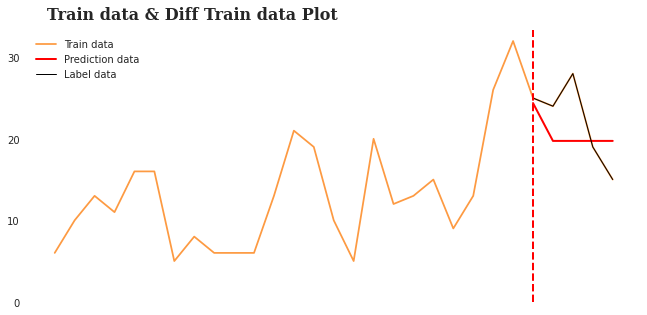

In [70]:
fig, ax = plt.subplots(1,1, figsize=(11,5))

ax.plot(sample_series, label="Train data", color=YlOrBr_palette[4])
ax.plot(np.arange(0,len(pred)) + len(train_sample),pred, label="Prediction data",color='r', linewidth=2)
ax.plot(test_sample, label="Label data",color='k', linewidth=1)
        
ax.axvline(x=len(train_sample), color='r',linestyle='--', linewidth=2)

ax.set_yticks(np.arange(0,31,10))
ax.set_xticks([])

ax.legend()
ax.patch.set_alpha(0)

fig.text(0.15,0.91,"Train data & Diff Train data Plot", fontweight="bold", fontfamily='serif', fontsize=16)
plt.show()

### 5-2) LightGBM Modeling
* Divide the data into training, testing and evaluatio
* Training

##### 5-2-1) Divide the data into training, testing and evaluatio

In [71]:
x = train_df.drop('item_cnt_month', axis=1)
y = train_df['item_cnt_month']

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("X train data shape : {}".format(x_train.shape))
print("Y train data shape : {}".format(y_train.shape))

print("X test data shape : {}".format(x_test.shape))
print("Y test data shape : {}".format(y_test.shape))

X train data shape : (1125755, 5)
Y train data shape : (1125755,)
X test data shape : (482467, 5)
Y test data shape : (482467,)


In [73]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.6)
print("X validation data shape : {}".format(x_val.shape))
print("Y validation data shape : {}".format(y_val.shape))

print("X test data shape : {}".format(x_test.shape))
print("Y test data shape : {}".format(y_test.shape))

X validation data shape : (289481, 5)
Y validation data shape : (289481,)
X test data shape : (192986, 5)
Y test data shape : (192986,)


##### 5-2-1) Training

In [74]:
import lightgbm as lgb
from lightgbm import plot_importance

In [75]:
train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)

In [76]:
params = {
    'device' : 'gpu',
    'n_estimators': 5000,
    'num_leaves': 255,
    'max_depth': 20,
    'min_data_in_leaf': 1000,
    'learning_rate': 0.02,
    'boosting': 'gbdt',
    'num_boost_round': 3000,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.7,
    'objective': 'mse',
    'metric': 'rmse',
    'n_jobs': -1
}

In [77]:
model = lgb.train(params,
                  train_data,
                  valid_sets=(train_data, val_data), 
                  verbose_eval=20,
                  early_stopping_rounds=100)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1125755, number of used features: 5
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (8.59 MB) transferred to GPU in 0.011057 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 2.185981
Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 4.12184	valid_1's rmse: 4.18227
[40]	training's rmse: 3.92104	valid_1's rmse: 3.98809
[60]	training's rmse: 3.79497	valid_1's rmse: 3.8669
[80]	training's rmse: 3.70825	valid_1's rmse: 3.7834
[100]	training's rmse: 3.6524	valid_1's rmse: 3.73001
[120]	training's rmse: 3.61199	valid_1's rmse: 3.69162
[140]	training's rmse: 3.57532	valid_1'

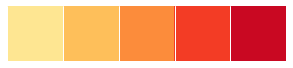

In [78]:
YlOrBr_palette_5 = sns.color_palette("YlOrRd", 5)
sns.palplot(YlOrBr_palette_5)

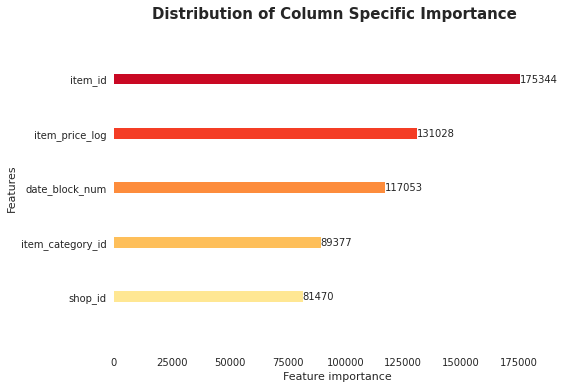

In [79]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
plot_importance(model, max_num_features=5,color=YlOrBr_palette_5, ax=ax)
ax.set_title("Distribution of Column Specific Importance ", fontweight="bold", fontsize=15)
ax.patch.set_alpha(0) 
plt.show()

# 6. Submission
* Submit the predictions

In [80]:
submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
test_df.head()

,shop_id,item_id,date_block_num,item_category_id,item_price_log
0,5,5037,34,19,7.312553
1,5,5320,34,55,6.107023
2,5,5233,34,19,7.089243
3,5,5232,34,23,7.089243
4,5,5268,34,20,6.107023


In [81]:
pred = model.predict(test_df)
pred = list(x if x>0 else 0 for x in pred)

submission['item_cnt_month'] = pred
submission.head()

,ID,item_cnt_month
0,0,0.145260
1,1,1.976594
2,2,0.129688
3,3,0.000000
4,4,2.810479


In [82]:
submission.to_csv('lgbm_submission1.csv', index=False)

##### reference 
* https://www.kaggle.com/tylerchenchen/predict-sales-problem-step-by-step-part1
* https://byeongkijeong.github.io/ARIMA-with-Python/
* https://www.youtube.com/watch?v=rdR2fNDq6v0

###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈